<a href="https://colab.research.google.com/github/Sim98B/TabularDataGeneration/blob/main/BrainTumor/BrainTumorConditionalImageGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Conditional Image Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Breast-Cancer-Data)
3. [A stronger model](#Wassesrstein-GAN-with-Gradient-Penalty)
4. [Are the data good enough?](#Data-Evaluation)
5. [Validation Protocol](#TOR-TS-protocol)
6. [Latent Evaluation](#Principal-Component-Analysis)
7. [Conclusion](#Conclusion)

In [1]:
import sys
import os
import shutil

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils

import random
from tqdm.auto import tqdm
import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
!git clone https://github.com/Sim98B/TabularDataGeneration.git

sys.path.append("TabularDataGeneration")
import utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Actual device: {device}')

Cloning into 'TabularDataGeneration'...
remote: Enumerating objects: 4139, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 4139 (delta 93), reused 76 (delta 40), pack-reused 3968 (from 1)
Receiving objects: 100% (4139/4139), 160.37 MiB | 22.46 MiB/s, done.
Resolving deltas: 100% (524/524), done.
Updating files: 100% (3283/3283), done.
Actual device: cuda


In [3]:
tumor_mapping = {0: 'Clear', 1: 'Glioma', 2: 'Meningioma', 3: 'Pituitary'}
section_mapping = {0: 'Axial', 1: 'Coronal', 2: 'Sagittal'}

feature_dim = 64
BS = 64

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []  # (tumor_type, section_type)

        tumor_types = sorted(os.listdir(root_dir))
        self.tumor_dict = {tumor: i for i, tumor in enumerate(tumor_types)}

        for tumor in tumor_types:
            tumor_path = os.path.join(root_dir, tumor)
            if not os.path.isdir(tumor_path):
                continue

            section_types = sorted(os.listdir(tumor_path))
            self.section_dict = {section: i for i, section in enumerate(section_types)}

            for section in section_types:
                section_path = os.path.join(tumor_path, section)
                if not os.path.isdir(section_path):
                    continue

                for img_name in os.listdir(section_path):
                    img_path = os.path.join(section_path, img_name)
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(img_path)
                        self.labels.append((self.tumor_dict[tumor], self.section_dict[section]))
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        tumor_label, section_label = self.labels[idx]

        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, (tumor_label, section_label)

transform = transforms.Compose([
    transforms.Resize((feature_dim, feature_dim)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5])
])

dataset = BrainTumorDataset(root_dir = "TabularDataGeneration/BrainTumor/Data", transform = transform)
dataloader = DataLoader(dataset, batch_size = BS, shuffle = True)

for images, labels in dataloader:
    print(f"Batch: {images.shape}")
    print(f"Tumor Labels: {[tumor_mapping[int(i)] for i in labels[0]]}")
    print(f"Section Label: {[section_mapping[int(i)] for i in labels[1]]}")
    break

Batch: torch.Size([64, 1, 64, 64])
Tumor Labels: ['Pituitary', 'Pituitary', 'Pituitary', 'Pituitary', 'Pituitary', 'Glioma', 'Glioma', 'Glioma', 'Meningioma', 'Meningioma', 'Pituitary', 'Meningioma', 'Glioma', 'Glioma', 'Pituitary', 'Pituitary', 'Clear', 'Meningioma', 'Clear', 'Meningioma', 'Pituitary', 'Meningioma', 'Glioma', 'Glioma', 'Meningioma', 'Glioma', 'Pituitary', 'Pituitary', 'Meningioma', 'Pituitary', 'Clear', 'Meningioma', 'Pituitary', 'Meningioma', 'Pituitary', 'Meningioma', 'Glioma', 'Glioma', 'Meningioma', 'Glioma', 'Pituitary', 'Glioma', 'Pituitary', 'Meningioma', 'Pituitary', 'Meningioma', 'Glioma', 'Pituitary', 'Pituitary', 'Glioma', 'Meningioma', 'Glioma', 'Pituitary', 'Meningioma', 'Clear', 'Meningioma', 'Glioma', 'Meningioma', 'Pituitary', 'Glioma', 'Meningioma', 'Meningioma', 'Pituitary', 'Meningioma']
Section Label: ['Sagittal', 'Coronal', 'Coronal', 'Sagittal', 'Coronal', 'Coronal', 'Sagittal', 'Sagittal', 'Axial', 'Coronal', 'Sagittal', 'Sagittal', 'Axial', 'Co

1: Clear  Sagittal
2: Clear  Axial
3: Clear  Axial
4: Pituitary  Sagittal
5: Glioma  Coronal
6: Glioma  Coronal
7: Glioma  Sagittal
8: Pituitary  Coronal
9: Glioma  Sagittal
10: Clear  Coronal
11: Glioma  Axial
12: Pituitary  Coronal
13: Clear  Axial
14: Glioma  Axial
15: Glioma  Axial
16: Pituitary  Sagittal
17: Pituitary  Axial
18: Meningioma  Sagittal
19: Pituitary  Axial
20: Meningioma  Coronal
21: Pituitary  Axial
22: Clear  Axial
23: Pituitary  Axial
24: Clear  Sagittal
25: Clear  Axial
26: Meningioma  Axial
27: Pituitary  Coronal
28: Glioma  Coronal
29: Glioma  Sagittal
30: Glioma  Sagittal
31: Glioma  Axial
32: Meningioma  Axial
33: Glioma  Coronal
34: Pituitary  Sagittal
35: Glioma  Axial
36: Glioma  Coronal
37: Meningioma  Coronal
38: Meningioma  Axial
39: Glioma  Coronal
40: Meningioma  Axial
41: Glioma  Sagittal
42: Glioma  Axial
43: Meningioma  Coronal
44: Meningioma  Axial
45: Meningioma  Axial
46: Meningioma  Axial
47: Clear  Axial
48: Clear  Axial
49: Pituitary  Coronal

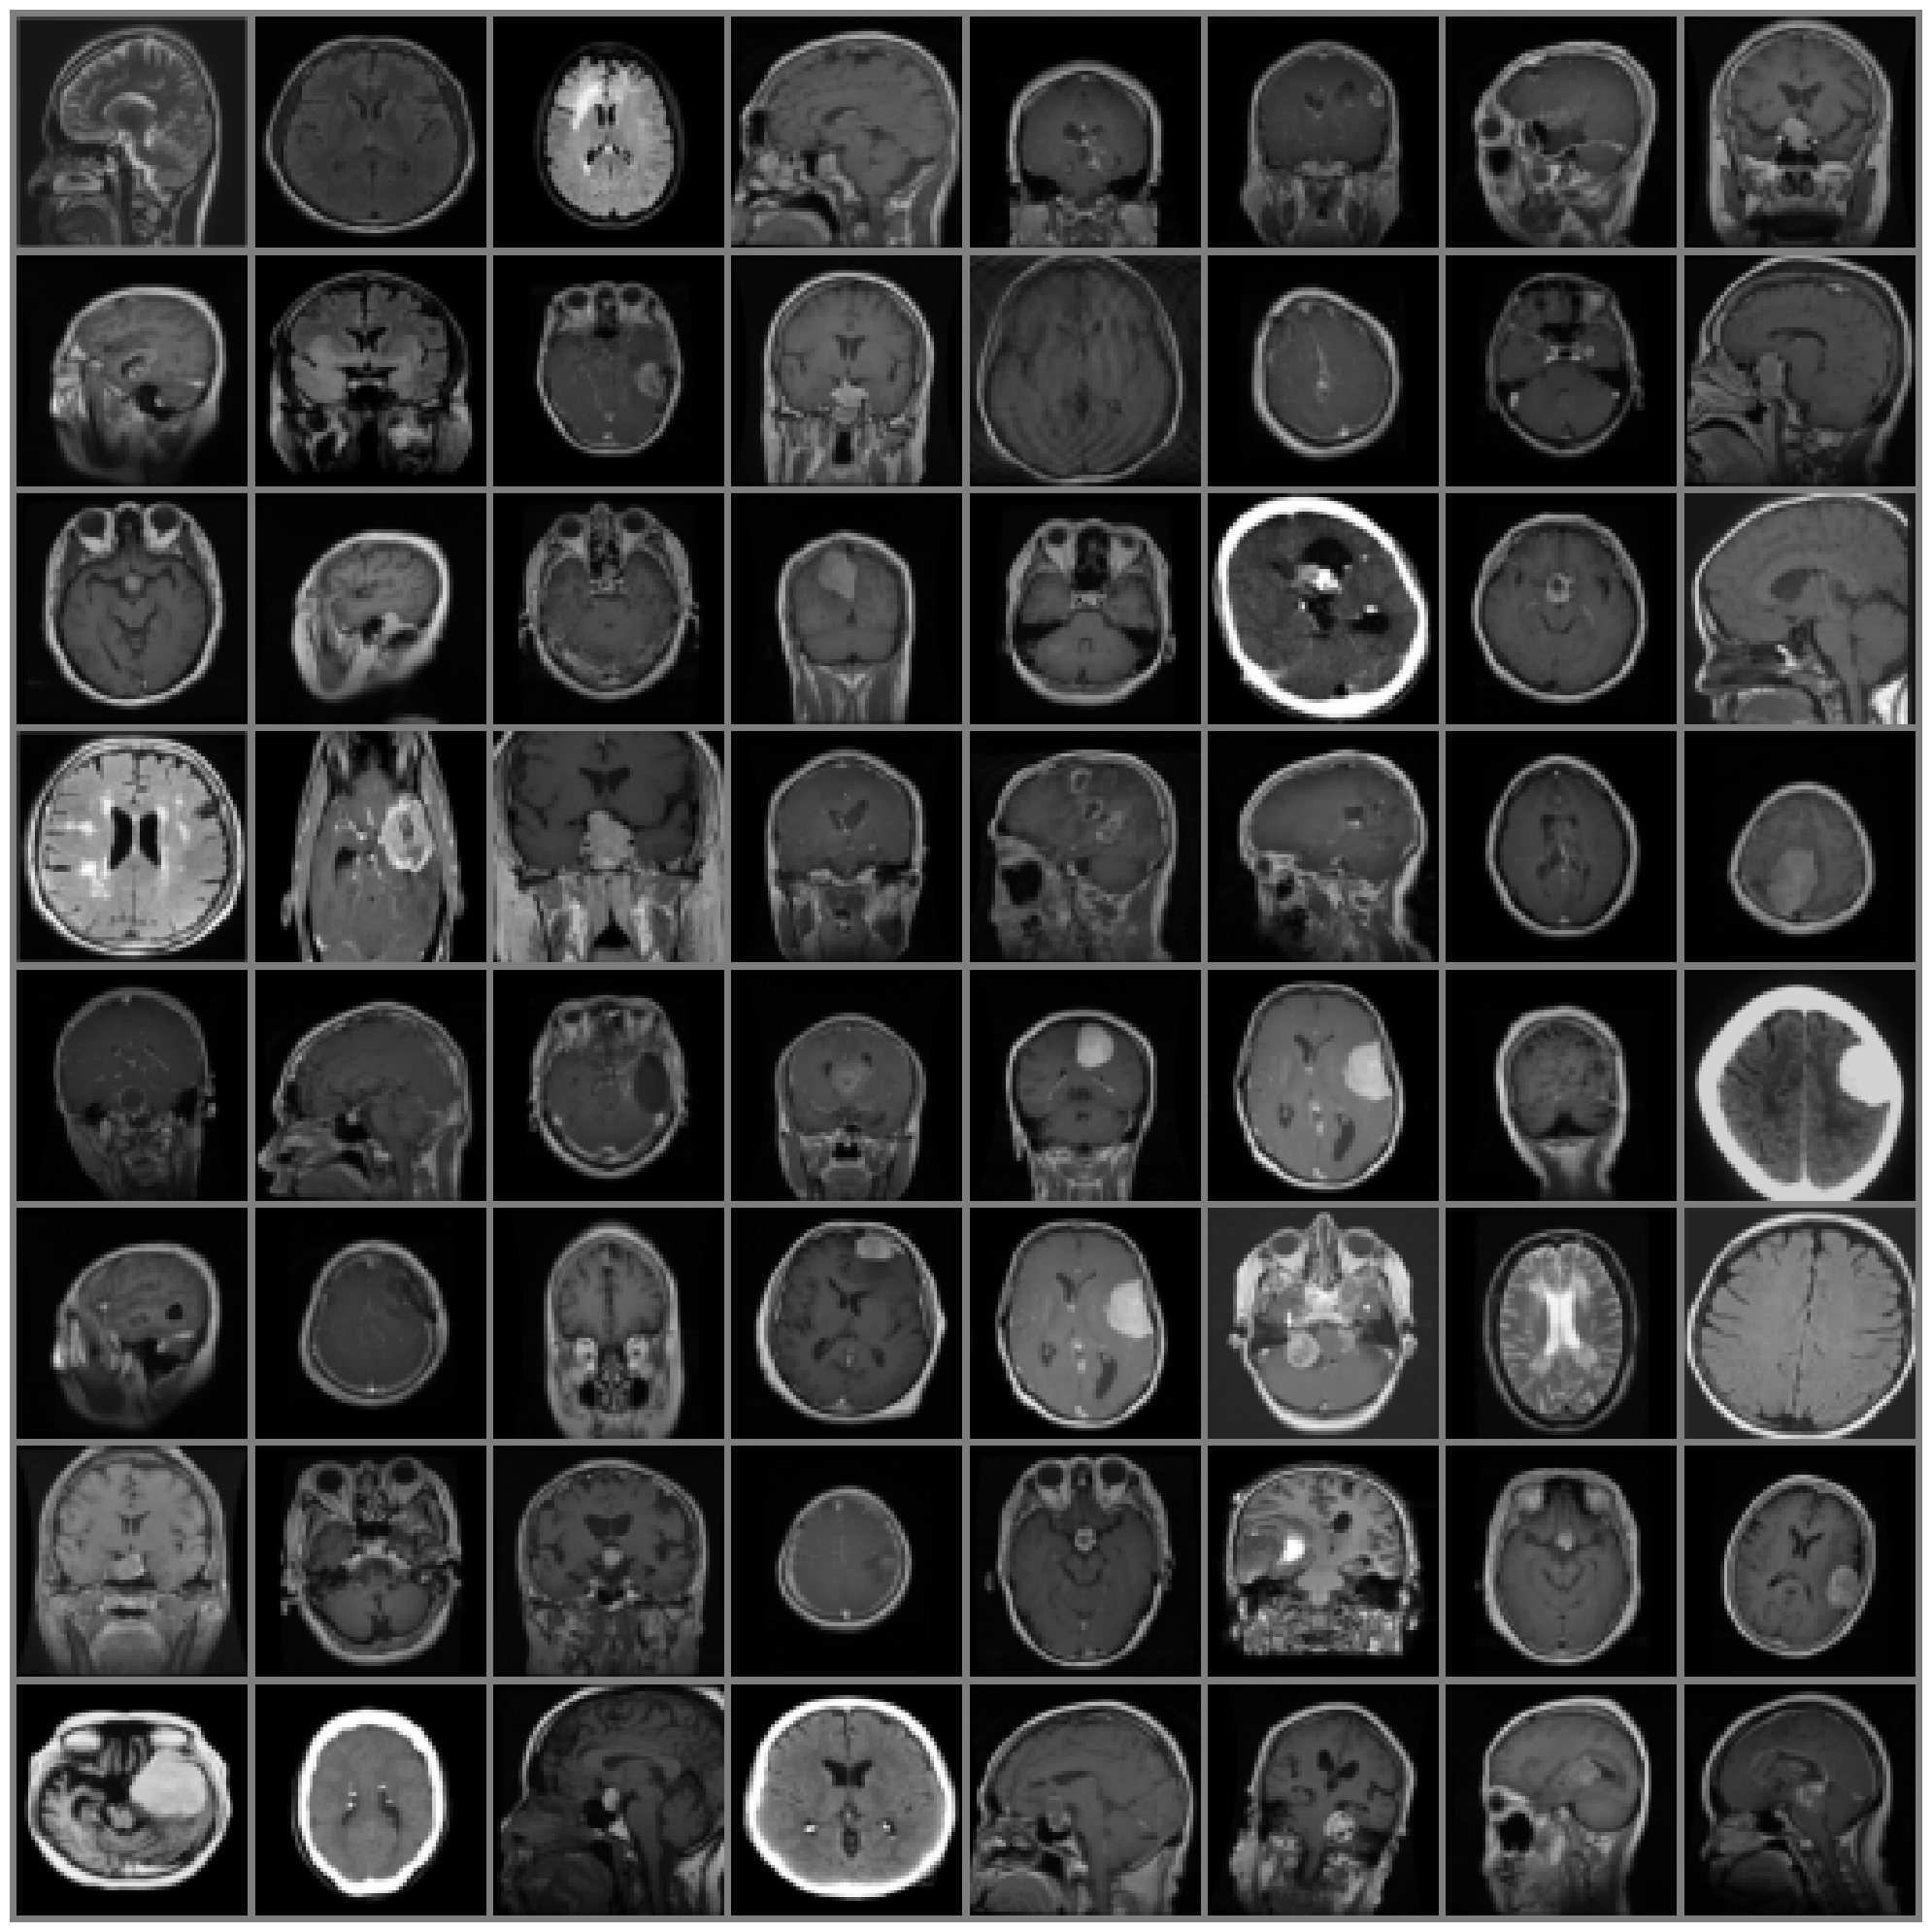

In [4]:
num_images = 64

dataiter = iter(dataloader)
images, labels = next(dataiter)

tumor_name = [tumor_mapping[int(i)] for i in labels[0][:num_images]]
section_name = [section_mapping[int(i)] for i in labels[1][:num_images]]
scan_name = [f"{tumor_name[i]}  {section_name[i]}" for i in range(len(tumor_name))]

for idx, label in enumerate(scan_name):
  print(f"{idx + 1}: {label}")
images = images[:num_images]
grid_img = vutils.make_grid(images, nrow = int(num_images ** 0.5), normalize = True, pad_value = 0.5)
plt.figure(figsize = (int(num_images ** 0.5)*2.5,(int(num_images ** 0.5)*2.5)))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.tight_layout();

In [5]:
class WCriticTinyVGG(nn.Module):
  def __init__(self, tumor_classes, section_classes, feature_dim):
        super(WCriticTinyVGG, self).__init__()

        self.Conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3)
        )

        self.Conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.Conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3)
        )

        self.Conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.fc_features = None

        self.fc_tumor = nn.Embedding(tumor_classes, feature_dim // 2)
        self.fc_section = nn.Embedding(section_classes, feature_dim // 2)

        self.fc_wasserstein = None

        self._initialize_fc(feature_dim)

  def _initialize_fc(self, feature_dim):
      with torch.no_grad():
          dummy = torch.randn(1, 1, feature_dim, feature_dim)
          out = self.Conv1(dummy)
          out = self.Conv2(out)
          out = self.Conv3(out)
          out = self.Conv4(out)
          flatten_dim = out.shape[1] * out.shape[2] * out.shape[3]
      self.fc_features = nn.Linear(flatten_dim, feature_dim)
      self.fc_wasserstein = nn.Linear(feature_dim * 2, 1)

  def forward(self, x, tumor_labels, section_labels):
    x = self.Conv1(x)
    x = self.Conv2(x)
    x = self.Conv3(x)
    x = self.Conv4(x)

    x = torch.flatten(x, start_dim = 1)
    x = self.fc_features(x)

    tumor_emb = self.fc_tumor(tumor_labels)
    section_emb = self.fc_section(section_labels)

    x = torch.cat((x, tumor_emb, section_emb), dim=1)

    x = self.fc_wasserstein(x)

    return x


class WGeneratorTinyVGG(nn.Module):
    def __init__(self, tumor_classes, section_classes, feature_dim, latent_dim = 100):
        super(WGeneratorTinyVGG, self).__init__()

        self.latent_dim = latent_dim

        self.fc_tumor = nn.Embedding(tumor_classes, feature_dim // 2)
        self.fc_section = nn.Embedding(section_classes, feature_dim // 2)

        self.fc_input = nn.Linear(latent_dim + feature_dim, 10 * 13 * 13)

        self.TConv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 10, kernel_size = 2, stride = 1),
            nn.LeakyReLU(0.2)
        )

        self.TConv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 2, output_padding = 1),
            nn.LeakyReLU(0.2)
        )

        self.TConv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 10, kernel_size = 2, stride = 1),
            nn.LeakyReLU(0.2)
        )

        self.TConv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 1, kernel_size = 3, stride = 2, output_padding = 1),
            nn.Tanh()
        )

    def forward(self, z, tumor_labels, section_labels):
        tumor_emb = self.fc_tumor(tumor_labels)
        section_emb = self.fc_section(section_labels)

        x = torch.cat((z, tumor_emb, section_emb), dim = 1)
        x = self.fc_input(x)

        x = x.view(-1, 10, 13, 13)

        x = self.TConv1(x)
        x = self.TConv2(x)
        x = self.TConv3(x)
        x = self.TConv4(x)

        return x


utils.set_seed()
crit = WCriticTinyVGG(tumor_classes = len(tumor_mapping), section_classes = len(section_mapping), feature_dim = feature_dim)
gen = WGeneratorTinyVGG(tumor_classes = len(tumor_mapping), section_classes = len(section_mapping), feature_dim = feature_dim)
print(f"Critic output shape: {crit(images, labels[0], labels[1]).shape}")
print(f'Critic parameters: {sum(p.numel() for p in crit.parameters())/1000}k')
print(f"Generator output shape: {gen(torch.randn(BS, 100), labels[0], labels[1]).shape}")
print(f'Generator parameters: {sum(p.numel() for p in gen.parameters())/1000}k')

Critic output shape: torch.Size([64, 1])
Critic parameters: 111.407k
Generator output shape: torch.Size([64, 1, 64, 64])
Generator parameters: 280.895k


In [6]:
def gradient_penalty(
    critic: torch.nn.Module,
    real_data: torch.Tensor,
    fake_data: torch.Tensor,
    tumor_labels: torch.Tensor,
    section_labels: torch.Tensor,
    lambda_gp: float = 10
):
    """
    Calculates the gradient penalty term for stabilizing WGAN-GP training.

    Args:
        critic (torch.nn.Module): The critic (discriminator) that evaluates real and generated data.
        real_data (torch.Tensor): Batch of real data with shape (batch_size, feature_dim).
        fake_data (torch.Tensor): Batch of generated data with shape (batch_size, feature_dim).
        tumor_labels (torch.Tensor): Tumor type labels.
        section_labels (torch.Tensor): Section type labels.
        lambda_gp (float, optional): Coefficient for the gradient penalty. Default: 10.

    Returns:
        torch.Tensor: Scaled gradient penalty value to be added to the critic's loss.
    """
    batch_size = real_data.size(0)
    device = real_data.device  # Assicuriamoci di operare sullo stesso device

    # Generiamo pesi casuali per l'interpolazione
    epsilon = torch.rand(batch_size, 1, 1, 1, device=real_data.device)  # Aggiungiamo dimensioni extra
    epsilon = epsilon.expand_as(real_data)  # Ora combacia con [batch_size, channels, height, width]

    # Interpoliamo tra real_data e fake_data
    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated.requires_grad_(True)

    # Calcoliamo il punteggio per i dati interpolati, passando entrambe le etichette
    interpolated_score = critic(interpolated, tumor_labels, section_labels)

    # Calcoliamo il gradiente
    grad_outputs = torch.ones_like(interpolated_score)
    gradients = torch.autograd.grad(
        outputs=interpolated_score,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Calcoliamo la norma del gradiente e la penalità
    gradients_norm = gradients.view(batch_size, -1).norm(2, dim=1)
    penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()

    return penalty

def critic_loss(
    critic: torch.nn.Module,
    real_data: torch.Tensor,
    fake_data: torch.Tensor,
    tumor_labels: torch.Tensor,
    section_labels: torch.Tensor,
    lambda_gp: float = 10
):
    """
    Calculates the critic loss for a WGAN-GP, including the gradient penalty.

    Args:
        critic (torch.nn.Module): The critic (discriminator) that evaluates real and generated data.
        real_data (torch.Tensor): Batch of real data with shape (batch_size, feature_dim).
        fake_data (torch.Tensor): Batch of generated data with shape (batch_size, feature_dim).
        tumor_labels (torch.Tensor): Tumor type labels.
        section_labels (torch.Tensor): Section type labels.
        lambda_gp (float, optional): Coefficient for the gradient penalty. Default: 10.

    Returns:
        torch.Tensor: Scaled value of the critic's loss.
    """
    real_score = critic(real_data, tumor_labels, section_labels)
    fake_score = critic(fake_data, tumor_labels, section_labels)

    wasserstein_loss = fake_score.mean() - real_score.mean()

    gp = gradient_penalty(critic, real_data, fake_data, tumor_labels, section_labels, lambda_gp)
    return wasserstein_loss + gp

def generator_loss(critic: torch.nn.Module, fake_data: torch.Tensor, tumor_labels: torch.Tensor, section_labels: torch.Tensor):
    """
    Calculates the loss of the generator in a WGAN-GP for image generation.

    Args:
        critic (torch.nn.Module): The critic (discriminator) that evaluates real and generated data.
        fake_data (torch.Tensor): Batch of generated images with shape (batch_size, 1, H, W).
        tumor_labels (torch.Tensor): Tensor with tumor class labels.
        section_labels (torch.Tensor): Tensor with section class labels.

    Returns:
        torch.Tensor: Scaled value of the generator loss.
    """
    fake_score = critic(fake_data, tumor_labels, section_labels)
    return -fake_score.mean()

In [7]:
data = images
fake_data = gen(torch.randn(BS, 100), labels[0], labels[1]).detach().cpu()
print(critic_loss(crit, data, fake_data, labels[0], labels[1]))
print(generator_loss(crit, fake_data, labels[0], labels[1]))

tensor(9.8421, grad_fn=<AddBackward0>)
tensor(0.1785, grad_fn=<NegBackward0>)


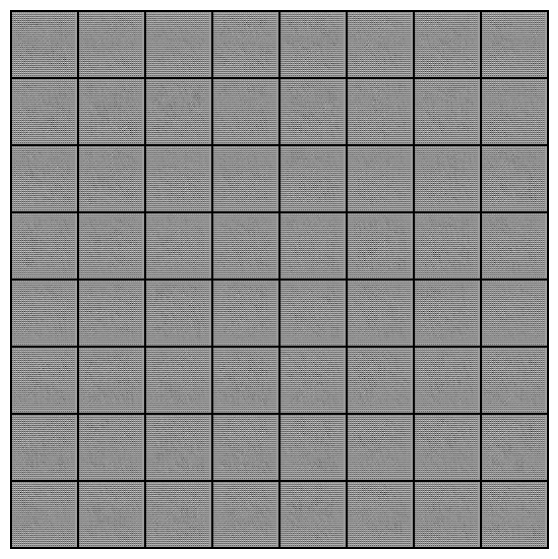

In [8]:
utils.set_seed()
noise = torch.randn(BS, 100)

tumor_labels = torch.randint(low = 0, high = 4, size = (BS,))
section_label = torch.randint(low = 0, high = 3, size = (BS,))
utils.generate_images(gen, noise, tumor_labels, section_label, BS)

In [9]:
load_pretrained = True
models_path = 'TabularDataGeneration/BrainTumor/Models/'

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

if load_pretrained:
  print('Parameters loaded!')
  crit.load_state_dict(torch.load(models_path + "TinyVGGcritic.pth"))
  gen.load_state_dict(torch.load(models_path + "TinyVGGgenerator.pth"))
else:
  print('Parameters initialized')
  crit.apply(weights_init)
  gen.apply(weights_init)

g_lr = 5e-4
c_lr = 2e-3

g_opt = torch.optim.Adam(gen.parameters(), lr = g_lr, betas = (0.5, 0.999))
c_opt = torch.optim.RMSprop(crit.parameters(), lr = c_lr, weight_decay = 0)

utils.set_seed()
z = torch.randn(BS, 100)

fixed_tumor_labels = torch.randint(low = 0, high = 4, size = (BS,))
fixed_section_label = torch.randint(low = 0, high = 3, size = (BS,))

Parameters loaded!


Training Model:   0%|          | 0/201 [00:00<?, ?it/s]

Epoch0/200 | CLoss: -43.3663 | GLoss: 33.4658


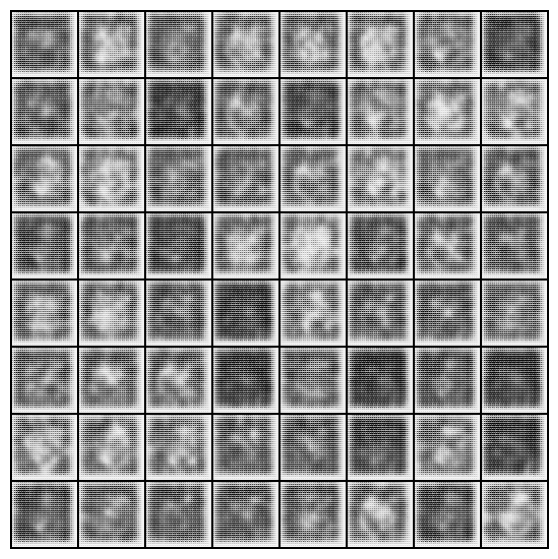

Epoch1/200 | CLoss: -28.1446 | GLoss: 46.5322
Epoch2/200 | CLoss: -24.6358 | GLoss: 36.2002
Epoch3/200 | CLoss: -25.5629 | GLoss: 36.6244
Epoch4/200 | CLoss: -24.6294 | GLoss: 33.2146
Epoch5/200 | CLoss: -26.5529 | GLoss: 33.1712
Epoch6/200 | CLoss: -26.6616 | GLoss: 28.6438
Epoch7/200 | CLoss: -25.8586 | GLoss: 25.5326
Epoch8/200 | CLoss: -25.0789 | GLoss: 30.0937
Epoch9/200 | CLoss: -23.8987 | GLoss: 33.2765
Epoch10/200 | CLoss: -22.1253 | GLoss: 37.5694
Epoch11/200 | CLoss: -20.0887 | GLoss: 38.3124
Epoch12/200 | CLoss: -17.9746 | GLoss: 36.3300
Epoch13/200 | CLoss: -16.6922 | GLoss: 36.3352
Epoch14/200 | CLoss: -15.6938 | GLoss: 38.8840
Epoch15/200 | CLoss: -15.1110 | GLoss: 38.8419
Epoch16/200 | CLoss: -14.6057 | GLoss: 38.0580
Epoch17/200 | CLoss: -14.3963 | GLoss: 34.4687
Epoch18/200 | CLoss: -14.1092 | GLoss: 35.7693
Epoch19/200 | CLoss: -12.3967 | GLoss: 39.1000
Epoch20/200 | CLoss: -13.4916 | GLoss: 39.0347


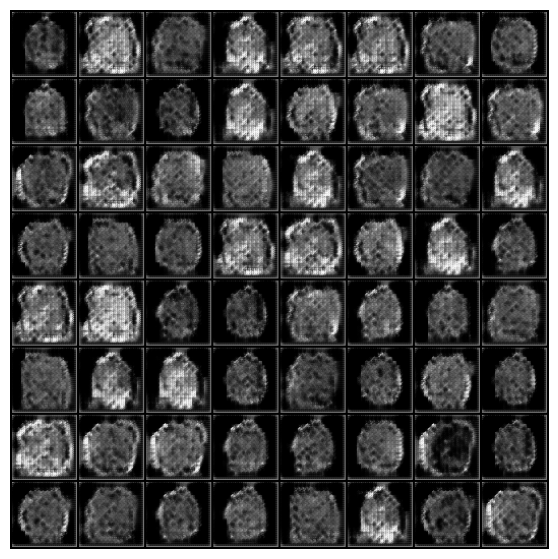

Epoch21/200 | CLoss: -13.1843 | GLoss: 36.9056
Epoch22/200 | CLoss: -12.9258 | GLoss: 37.7411
Epoch23/200 | CLoss: -12.7157 | GLoss: 40.2598
Epoch24/200 | CLoss: -12.3772 | GLoss: 39.8731
Epoch25/200 | CLoss: -12.0244 | GLoss: 41.7921
Epoch26/200 | CLoss: -11.9165 | GLoss: 42.9406
Epoch27/200 | CLoss: -11.7585 | GLoss: 44.9289
Epoch28/200 | CLoss: -11.3732 | GLoss: 46.7461
Epoch29/200 | CLoss: -11.3583 | GLoss: 47.8476
Epoch30/200 | CLoss: -10.9504 | GLoss: 44.6209
Epoch31/200 | CLoss: -10.7815 | GLoss: 46.4750
Epoch32/200 | CLoss: -10.6106 | GLoss: 46.7528
Epoch33/200 | CLoss: -10.3768 | GLoss: 50.2760
Epoch34/200 | CLoss: -10.2421 | GLoss: 52.4879
Epoch35/200 | CLoss: -10.0779 | GLoss: 53.8220
Epoch36/200 | CLoss: -9.7765 | GLoss: 54.4358
Epoch37/200 | CLoss: -9.6482 | GLoss: 57.5593
Epoch38/200 | CLoss: -9.4569 | GLoss: 57.2264
Epoch39/200 | CLoss: -9.1777 | GLoss: 56.4365
Epoch40/200 | CLoss: -8.9898 | GLoss: 55.5069


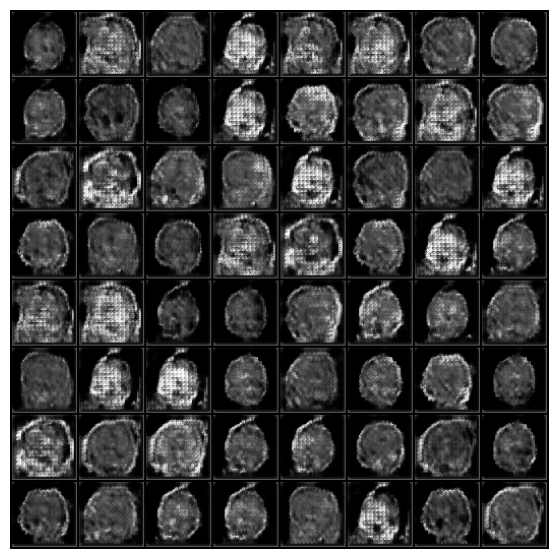

Epoch41/200 | CLoss: -8.8810 | GLoss: 56.6565
Epoch42/200 | CLoss: -8.6412 | GLoss: 57.7911
Epoch43/200 | CLoss: -8.5058 | GLoss: 55.8198
Epoch44/200 | CLoss: -8.3641 | GLoss: 56.6374
Epoch45/200 | CLoss: -8.1812 | GLoss: 57.8528
Epoch46/200 | CLoss: -7.9846 | GLoss: 55.4774
Epoch47/200 | CLoss: -7.8870 | GLoss: 56.8635
Epoch48/200 | CLoss: -7.7434 | GLoss: 56.3649
Epoch49/200 | CLoss: -7.5827 | GLoss: 55.5810
Epoch50/200 | CLoss: -7.4463 | GLoss: 55.1466
Epoch51/200 | CLoss: -7.3528 | GLoss: 56.5806
Epoch52/200 | CLoss: -7.1980 | GLoss: 55.2396
Epoch53/200 | CLoss: -7.1518 | GLoss: 55.4138
Epoch54/200 | CLoss: -7.0183 | GLoss: 55.1735
Epoch55/200 | CLoss: -6.9675 | GLoss: 54.7454
Epoch56/200 | CLoss: -6.7373 | GLoss: 52.7215
Epoch57/200 | CLoss: -6.7763 | GLoss: 50.9400
Epoch58/200 | CLoss: -6.6112 | GLoss: 49.4976
Epoch59/200 | CLoss: -6.5757 | GLoss: 51.6109
Epoch60/200 | CLoss: -6.5175 | GLoss: 51.8260


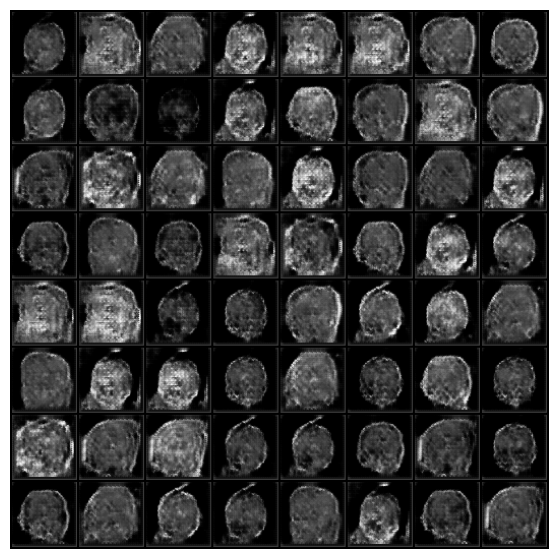

Epoch61/200 | CLoss: -6.3730 | GLoss: 51.3565
Epoch62/200 | CLoss: -6.2116 | GLoss: 50.7255
Epoch63/200 | CLoss: -6.0927 | GLoss: 48.0085
Epoch64/200 | CLoss: -6.0241 | GLoss: 47.9826
Epoch65/200 | CLoss: -6.0054 | GLoss: 47.1733
Epoch66/200 | CLoss: -5.9701 | GLoss: 47.9825
Epoch67/200 | CLoss: -5.8553 | GLoss: 47.8483
Epoch68/200 | CLoss: -5.7968 | GLoss: 46.4012
Epoch69/200 | CLoss: -5.7561 | GLoss: 47.6802
Epoch70/200 | CLoss: -5.4816 | GLoss: 44.3067
Epoch71/200 | CLoss: -5.5921 | GLoss: 42.9342
Epoch72/200 | CLoss: -5.4326 | GLoss: 44.2004
Epoch73/200 | CLoss: -5.3449 | GLoss: 45.7332
Epoch74/200 | CLoss: -5.2782 | GLoss: 48.2860
Epoch75/200 | CLoss: -5.1971 | GLoss: 45.3299
Epoch76/200 | CLoss: -5.1699 | GLoss: 49.4153
Epoch77/200 | CLoss: -5.1296 | GLoss: 48.1224
Epoch78/200 | CLoss: -5.0640 | GLoss: 48.6489
Epoch79/200 | CLoss: -5.0189 | GLoss: 50.1808
Epoch80/200 | CLoss: -4.9992 | GLoss: 50.3498


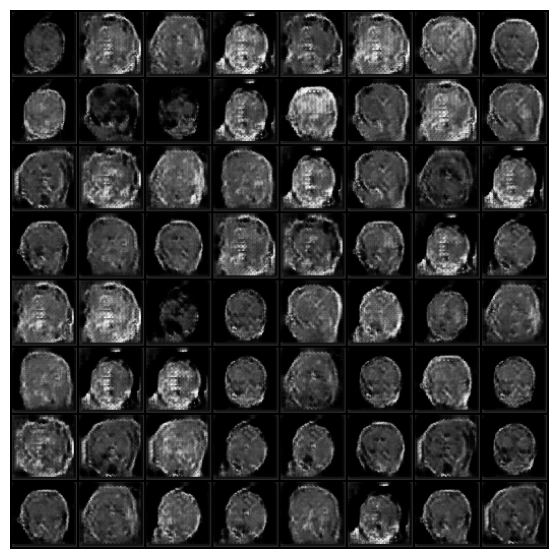

Epoch81/200 | CLoss: -4.9775 | GLoss: 52.1446
Epoch82/200 | CLoss: -4.9088 | GLoss: 52.7386
Epoch83/200 | CLoss: -4.8586 | GLoss: 52.2108
Epoch84/200 | CLoss: -4.7742 | GLoss: 50.0357
Epoch85/200 | CLoss: -4.7584 | GLoss: 51.4827
Epoch86/200 | CLoss: -4.6604 | GLoss: 50.2596
Epoch87/200 | CLoss: -4.6385 | GLoss: 53.9113
Epoch88/200 | CLoss: -4.5679 | GLoss: 52.4582
Epoch89/200 | CLoss: -4.5539 | GLoss: 52.6512
Epoch90/200 | CLoss: -4.5453 | GLoss: 54.8293
Epoch91/200 | CLoss: -4.5026 | GLoss: 52.9910
Epoch92/200 | CLoss: -4.4960 | GLoss: 53.7860
Epoch93/200 | CLoss: -4.4384 | GLoss: 52.2591
Epoch94/200 | CLoss: -4.4348 | GLoss: 54.2445
Epoch95/200 | CLoss: -4.4289 | GLoss: 51.9139
Epoch96/200 | CLoss: -4.3489 | GLoss: 50.0695
Epoch97/200 | CLoss: -4.2264 | GLoss: 48.4370
Epoch98/200 | CLoss: -4.3193 | GLoss: 47.7045
Epoch99/200 | CLoss: -4.0528 | GLoss: 47.0825
Epoch100/200 | CLoss: -4.2375 | GLoss: 50.0868


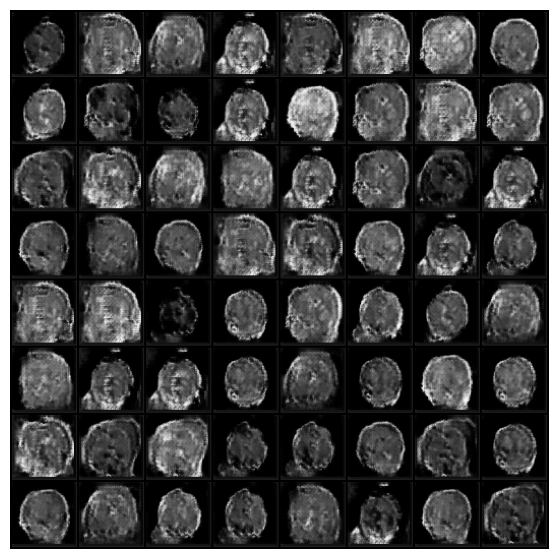

Epoch101/200 | CLoss: -4.0994 | GLoss: 47.4295
Epoch102/200 | CLoss: -4.1538 | GLoss: 46.4626
Epoch103/200 | CLoss: -4.1782 | GLoss: 50.2358
Epoch104/200 | CLoss: -4.1259 | GLoss: 48.5737
Epoch105/200 | CLoss: -4.0602 | GLoss: 45.4596
Epoch106/200 | CLoss: -4.0793 | GLoss: 49.3950
Epoch107/200 | CLoss: -4.0387 | GLoss: 49.7136
Epoch108/200 | CLoss: -4.0347 | GLoss: 51.9693
Epoch109/200 | CLoss: -3.8958 | GLoss: 49.8793
Epoch110/200 | CLoss: -3.9063 | GLoss: 49.5513
Epoch111/200 | CLoss: -3.8955 | GLoss: 49.5876
Epoch112/200 | CLoss: -3.9185 | GLoss: 50.3014
Epoch113/200 | CLoss: -3.9041 | GLoss: 50.2782
Epoch114/200 | CLoss: -3.8342 | GLoss: 47.2599
Epoch115/200 | CLoss: -3.8177 | GLoss: 50.2983
Epoch116/200 | CLoss: -3.7494 | GLoss: 49.5403
Epoch117/200 | CLoss: -3.8305 | GLoss: 47.9006
Epoch118/200 | CLoss: -3.7575 | GLoss: 51.9080
Epoch119/200 | CLoss: -3.7575 | GLoss: 49.5649
Epoch120/200 | CLoss: -3.7636 | GLoss: 48.9909


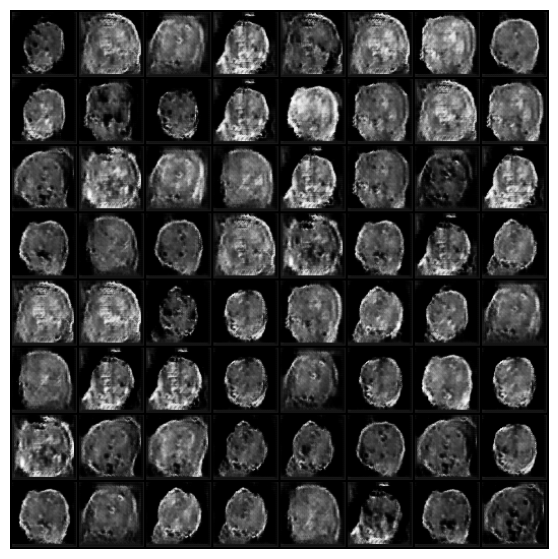

Epoch121/200 | CLoss: -3.7605 | GLoss: 49.2983
Epoch122/200 | CLoss: -3.6781 | GLoss: 47.2499
Epoch123/200 | CLoss: -3.7514 | GLoss: 48.7941
Epoch124/200 | CLoss: -3.6487 | GLoss: 50.1169
Epoch125/200 | CLoss: -3.5227 | GLoss: 49.4854
Epoch126/200 | CLoss: -3.6909 | GLoss: 54.3631
Epoch127/200 | CLoss: -3.7461 | GLoss: 52.4671
Epoch128/200 | CLoss: -3.6206 | GLoss: 51.2408
Epoch129/200 | CLoss: -3.7001 | GLoss: 50.9153
Epoch130/200 | CLoss: -3.6743 | GLoss: 51.7498
Epoch131/200 | CLoss: -3.5820 | GLoss: 50.3041
Epoch132/200 | CLoss: -3.6289 | GLoss: 50.0331
Epoch133/200 | CLoss: -3.5598 | GLoss: 49.9028
Epoch134/200 | CLoss: -3.5832 | GLoss: 52.5157
Epoch135/200 | CLoss: -3.5465 | GLoss: 51.1832
Epoch136/200 | CLoss: -3.6265 | GLoss: 51.0834
Epoch137/200 | CLoss: -3.5080 | GLoss: 50.2877
Epoch138/200 | CLoss: -3.5553 | GLoss: 50.5205
Epoch139/200 | CLoss: -3.5167 | GLoss: 45.9464
Epoch140/200 | CLoss: -3.5968 | GLoss: 42.9086


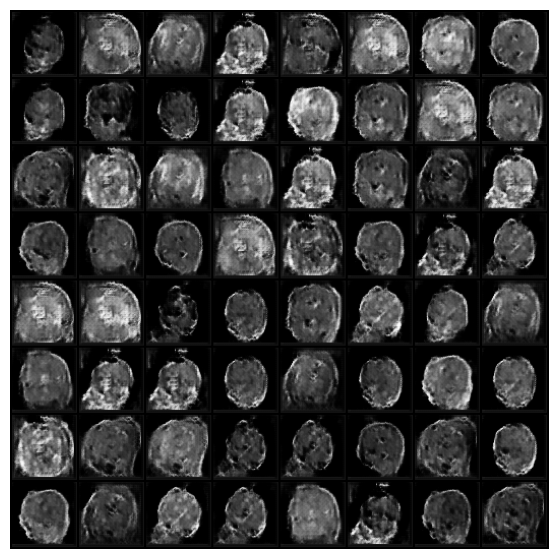

Epoch141/200 | CLoss: -3.5327 | GLoss: 41.8045
Epoch142/200 | CLoss: -3.1370 | GLoss: 37.2279
Epoch143/200 | CLoss: -3.4731 | GLoss: 45.6783
Epoch144/200 | CLoss: -3.4467 | GLoss: 36.3831
Epoch145/200 | CLoss: -3.4886 | GLoss: 40.9367
Epoch146/200 | CLoss: -3.4891 | GLoss: 40.8145
Epoch147/200 | CLoss: -3.4854 | GLoss: 38.3697
Epoch148/200 | CLoss: -3.4641 | GLoss: 40.6791
Epoch149/200 | CLoss: -3.3941 | GLoss: 36.5443
Epoch150/200 | CLoss: -3.4896 | GLoss: 38.4119
Epoch151/200 | CLoss: -3.5259 | GLoss: 38.4866
Epoch152/200 | CLoss: -3.4730 | GLoss: 38.5373
Epoch153/200 | CLoss: -3.4706 | GLoss: 42.4216
Epoch154/200 | CLoss: -3.5302 | GLoss: 39.5989
Epoch155/200 | CLoss: -3.4441 | GLoss: 38.7276
Epoch156/200 | CLoss: -3.4709 | GLoss: 40.2768
Epoch157/200 | CLoss: -3.4105 | GLoss: 38.6683
Epoch158/200 | CLoss: -3.4754 | GLoss: 37.1830
Epoch159/200 | CLoss: -3.4719 | GLoss: 35.2277
Epoch160/200 | CLoss: -3.3920 | GLoss: 35.8451


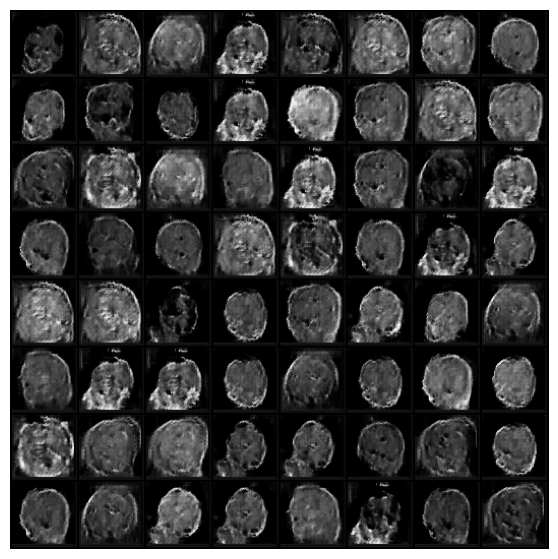

Epoch161/200 | CLoss: -3.4469 | GLoss: 37.6128
Epoch162/200 | CLoss: -3.4748 | GLoss: 38.4501
Epoch163/200 | CLoss: -3.4551 | GLoss: 36.9797
Epoch164/200 | CLoss: -3.5034 | GLoss: 40.4592
Epoch165/200 | CLoss: -3.4339 | GLoss: 41.0752
Epoch166/200 | CLoss: -3.4583 | GLoss: 41.3632
Epoch167/200 | CLoss: -3.4849 | GLoss: 40.0627
Epoch168/200 | CLoss: -3.4613 | GLoss: 37.3969
Epoch169/200 | CLoss: -3.3940 | GLoss: 41.5301
Epoch170/200 | CLoss: -3.4137 | GLoss: 39.1689
Epoch171/200 | CLoss: -3.4502 | GLoss: 35.6665
Epoch172/200 | CLoss: -3.4103 | GLoss: 35.3309
Epoch173/200 | CLoss: -3.4255 | GLoss: 38.7386
Epoch174/200 | CLoss: -3.3897 | GLoss: 37.7639
Epoch175/200 | CLoss: -3.4766 | GLoss: 37.9354
Epoch176/200 | CLoss: -3.4316 | GLoss: 38.0978
Epoch177/200 | CLoss: -3.4946 | GLoss: 41.0289
Epoch178/200 | CLoss: -3.4488 | GLoss: 37.7726
Epoch179/200 | CLoss: -3.4317 | GLoss: 35.9531
Epoch180/200 | CLoss: -3.3506 | GLoss: 38.2463


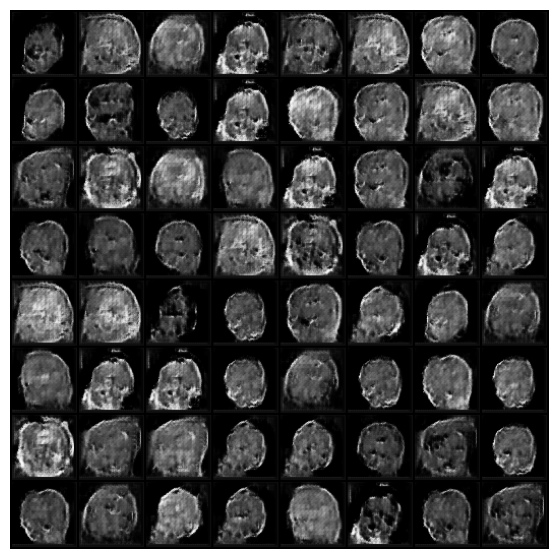

Epoch181/200 | CLoss: -3.4321 | GLoss: 38.0830
Epoch182/200 | CLoss: -3.3917 | GLoss: 38.1865
Epoch183/200 | CLoss: -3.3975 | GLoss: 39.4433
Epoch184/200 | CLoss: -3.3391 | GLoss: 39.4993
Epoch185/200 | CLoss: -3.3796 | GLoss: 39.9983
Epoch186/200 | CLoss: -3.4088 | GLoss: 42.1147
Epoch187/200 | CLoss: -3.4290 | GLoss: 38.9328
Epoch188/200 | CLoss: -3.3962 | GLoss: 38.0301
Epoch189/200 | CLoss: -3.3266 | GLoss: 38.9539
Epoch190/200 | CLoss: -3.3706 | GLoss: 39.4363
Epoch191/200 | CLoss: -3.3406 | GLoss: 40.1622
Epoch192/200 | CLoss: -3.3752 | GLoss: 40.3939
Epoch193/200 | CLoss: -3.3586 | GLoss: 42.1542
Epoch194/200 | CLoss: -3.3220 | GLoss: 42.8019
Epoch195/200 | CLoss: -3.3331 | GLoss: 41.9896
Epoch196/200 | CLoss: -3.3280 | GLoss: 45.0055
Epoch197/200 | CLoss: -3.3148 | GLoss: 44.5002
Epoch198/200 | CLoss: -3.3050 | GLoss: 43.1576
Epoch199/200 | CLoss: -3.3139 | GLoss: 43.8599
Epoch200/200 | CLoss: -3.3011 | GLoss: 42.6239


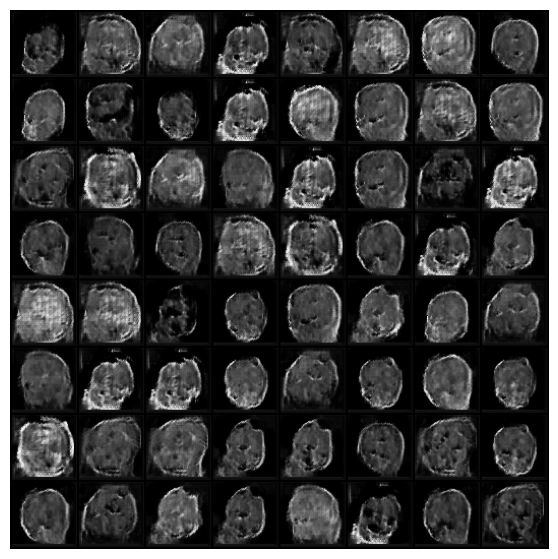

In [10]:
epochs = 200
verbose = 0.1
noise_dim = 100

for epoch in tqdm(range(epochs + 1), desc = 'Training Model'):

  gen = gen.to(device)
  crit = crit.to(device)

  gen.train()
  crit.train()

  gen_epoch_loss = 0
  crit_epoch_loss = 0

  for batch_idx, (data, labels) in enumerate(dataloader):

    data = data.to(device)
    tumor_labels = labels[0].to(device)
    section_labels = labels[1].to(device)

    noise = torch.randn(data.shape[0], noise_dim).to(device)
    fake_data = gen(noise, tumor_labels, section_labels)

    c_opt.zero_grad()
    crit_loss = critic_loss(crit, data, fake_data, tumor_labels, section_labels)
    crit_epoch_loss += crit_loss.item()
    crit_loss.backward()
    c_opt.step()

  if batch_idx % 5 == 0:

      noise = torch.randn(data.shape[0], noise_dim).to(device)
      fake_data = gen(noise, tumor_labels, section_labels)

      g_opt.zero_grad()
      gen_loss = generator_loss(crit, fake_data, tumor_labels, section_labels)
      gen_epoch_loss += gen_loss.item()
      gen_loss.backward()
      g_opt.step()

  g_epoch_loss = gen_epoch_loss/len(dataloader)
  c_epoch_loss = crit_epoch_loss/len(dataloader)
  print(f"Epoch{epoch}/{epochs} | CLoss: {c_epoch_loss:.4f} | GLoss: {g_epoch_loss:.4f}")

  if epoch % (epochs * 0.1) == 0 or epoch == epochs:
    #print(f"Epoch{epoch}/{epochs} | CLoss: {c_epoch_loss:.4f} | GLoss: {g_epoch_loss:.4f}")
    utils.generate_images(gen, z, fixed_tumor_labels, fixed_section_label, BS)

In [12]:
torch.save(crit.state_dict(), "TinyVGGcritic.pth")
torch.save(gen.state_dict(), "TinyVGGgenerator.pth")